# Song analysis
- Number of intro notes, song/call proportions, motif duration, coefficient of variation of motif durations
- Only use sessions where the number of song bouts >= 10
- Used all songs recorded from that day, if across multiple sessions

In [1]:
from deafening.plot import plot_across_days, plot_bar_comparison, plot_paired_data, plot_per_day_block
from database.load import ProjectLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from util import save
from util.stats import two_sample_ttest, paired_ttest, rank_sum_test, signed_rank_test

import warnings
warnings.filterwarnings('ignore')

nb_bout_crit = 10  # minimum number of bouts to measure the metrics

# SQL statement
query = f"SELECT * FROM song WHERE nbBoutsUndir >= {nb_bout_crit}"

# Load database
db = ProjectLoader().load_db()
df = db.to_dataframe(f"SELECT * FROM song WHERE nbBoutsUndir >= {nb_bout_crit}")
df['block10days'].replace(4, 3, inplace=True)  # include block 4 into block 3
df.head(10)

,id,birdID,taskName,taskSession,taskSessionDeafening,taskSessionPostDeafening,dph,block10days,sessionDate,songNote,...,nbMotifsUndir,nbMotifsDir,meanIntroUndir,meanIntroDir,songCallPropUndir,songCallPropDir,motifDurationUndir,motifDurationDir,motifDurationCVUndir,motifDurationCVDir
0,2,b70r38,Predeafening,19,-2,0,117,0,20190303,abcd,...,25,5,3.818,12.333,0.0268,0.1007,667.200,658.400,0.011,0.006
1,3,b70r38,Predeafening,20,-1,0,118,0,20190304,abcd,...,33,26,4.348,6.615,0.0486,0.0705,670.009,644.708,0.011,0.012
2,4,b70r38,Postdeafening,7,7,7,126,1,20190313,abcd,...,28,0,4.474,NaN,0.0069,NaN,653.154,NaN,0.010,NaN
3,5,b70r38,Postdeafening,10,10,10,129,1,20190316,abcd,...,27,0,5.950,NaN,0.0205,NaN,646.405,NaN,0.008,NaN
4,6,b70r38,Postdeafening,12,12,12,131,2,20190318,abcd,...,63,0,5.830,NaN,0.0483,NaN,632.964,NaN,0.012,NaN
5,7,b70r38,Postdeafening,13,13,13,132,2,20190319,abcd,...,133,13,6.908,8.500,0.0560,0.0330,628.836,615.358,0.013,0.019
6,8,b70r38,Postdeafening,15,15,15,134,2,20190321,abcd,...,91,22,5.667,5.895,0.0607,0.0554,613.183,607.693,0.011,0.011
7,9,b70r38,Postdeafening,16,16,16,135,2,20190322,abcd,...,97,0,5.909,NaN,0.1085,NaN,611.828,NaN,0.011,NaN
8,10,b70r38,Postdeafening,17,17,17,136,2,20190323,abcd,...,35,9,7.795,13.000,0.1020,0.0777,618.625,603.193,0.010,0.008
9,11,b70r38,Postdeafening,18,18,18,137,2,20190324,abcd,...,42,0,6.907,NaN,0.0972,NaN,610.306,NaN,0.012,NaN


In [2]:
# Parameters
fig_ext = '.png'
save_fig= False  # save figure to disk
save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'SongAnalysis', add_date=False)

## Mean # of intro notes

- Plots mean number of intro notes per song bout per day across days relative to deafening (= 0, vertical dash)
- Only counts from song bouts having at least one song note

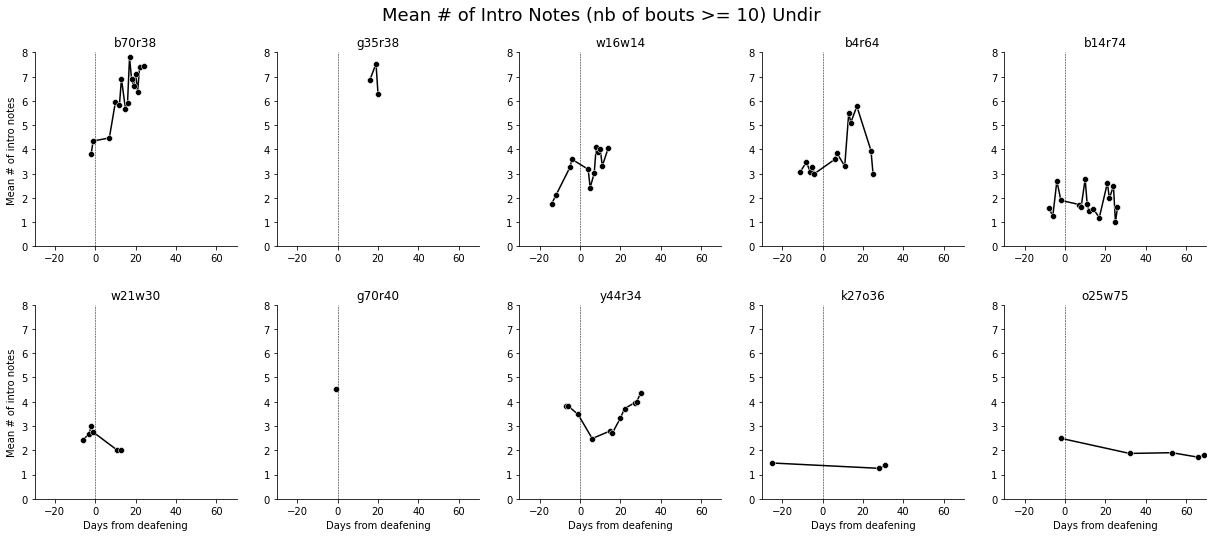

In [3]:
plot_across_days(df, x='taskSessionDeafening', y='meanIntroUndir', 
                 title=f"Mean # of Intro Notes (nb of bouts >= {nb_bout_crit}) Undir",
                 x_lim=[-30, 70],
                 y_lim=[0, 8],
                 x_label='Days from deafening', y_label='Mean # of intro notes',
                 fig_ext=fig_ext,
                 save_path=save_path,
                 save_fig=save_fig)

### Pre vs. Post

In [4]:
df_mean = df.groupby(['birdID', 'taskName'])['meanIntroUndir'].mean().reset_index()
df_mean = pd.pivot_table(data=df_mean,index=['birdID'], columns=['taskName'])['meanIntroUndir']
df_mean = df_mean.reindex(['Predeafening', 'Postdeafening'], axis=1)
df_mean

taskName,Predeafening,Postdeafening
birdID,,
b14r74,1.859250,1.815000
b4r64,3.178600,4.264625
b70r38,4.083000,6.492692
g35r38,NaN,6.895333
g70r40,4.538000,NaN
k27o36,1.476000,1.320500
o25w75,2.493000,1.825500
w16w14,2.682750,3.500250
w21w30,2.715000,2.000000


In [5]:
df_dropna = df_mean.dropna()  # remove if any of the columns is nan, used for paired comparisons
df_dropna

taskName,Predeafening,Postdeafening
birdID,,
b14r74,1.859250,1.815000
b4r64,3.178600,4.264625
b70r38,4.083000,6.492692
k27o36,1.476000,1.320500
o25w75,2.493000,1.825500
w16w14,2.682750,3.500250
w21w30,2.715000,2.000000
y44r34,3.713333,3.420125


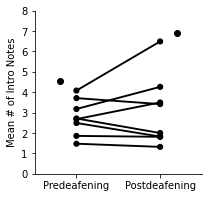

t(16) = -0.698806, p = 0.495 (two-sample t-test)
t(7) = -0.807, p = 0.446 (paired t-test)
Z = -0.132, p = 0.895 (rank-sum test)
Z = 15.0, p = 0.742 (signed-rank test)


In [6]:
plot_paired_data(df, x='taskName', y='meanIntroUndir',
                 y_label="Mean # of Intro Notes",
                 y_lim=[0, 8],
                 fig_size=(3, 3),
                 fig_name='f"Mean # of Intro Notes (nb of bouts >= {nb_bout_crit}) Undir"',
                 save_fig=False,
                 save_path=save_path,
                 color_by_bird=False,  # color-label birds
                 fig_ext='.png'
                 )
# Run stats
df_dropna = df_mean.dropna()  # remove if any of the columns is nan, used for paired comparisons

_, _, msg = two_sample_ttest(df_mean['Predeafening'].values, df_mean['Postdeafening'].values)
print(msg + " (two-sample t-test)")
_, _, msg = paired_ttest(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (paired t-test)")
_, _, msg = rank_sum_test(df_mean['Predeafening'].values, df_mean['Postdeafening'].values)
print(msg + " (rank-sum test)")
_, _, msg = signed_rank_test(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (signed-rank test)")

## Song - call proportions

- \# of calls / total # of notes (per song bout)
- higher value indicate the bird were more likely to insert calls within a song bout
- calls outside the song bout (bouts without any song notes) were not considered

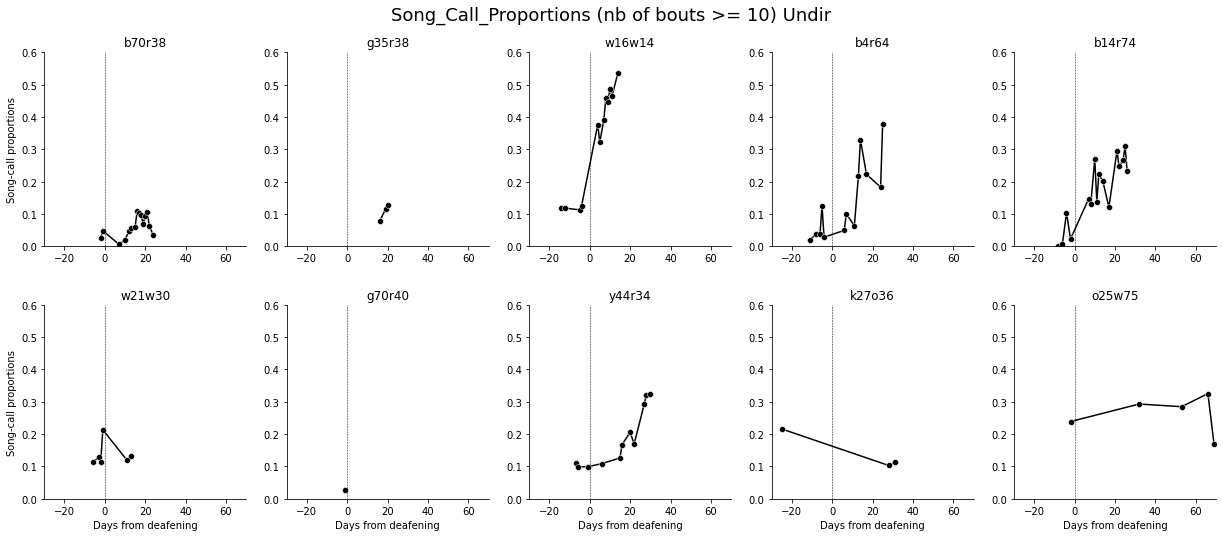

In [7]:
plot_across_days(df, x='taskSessionDeafening', y='songCallPropUndir',
                 title=f"Song_Call_Proportions (nb of bouts >= {nb_bout_crit}) Undir",
                 x_lim=[-30, 70],
                 y_lim=[0, 0.6],
                 x_label='Days from deafening', y_label='Song-call proportions',
                 fig_ext=fig_ext,
                 save_fig=save_fig)

### Pre vs. Post

In [8]:
df_mean = df.groupby(['birdID', 'taskName'])['songCallPropUndir'].mean().reset_index()
df_mean = pd.pivot_table(data=df_mean,index=['birdID'], columns=['taskName'])['songCallPropUndir']
df_mean = df_mean.reindex(['Predeafening', 'Postdeafening'], axis=1)
df_dropna = df_mean.dropna()  # remove if any of the columns is nan, used for paired comparisons
df_dropna
df_mean

taskName,Predeafening,Postdeafening
birdID,,
b14r74,0.033925,0.215642
b4r64,0.050200,0.193600
b70r38,0.037700,0.066969
g35r38,NaN,0.107500
g70r40,0.025700,NaN
k27o36,0.216000,0.107700
o25w75,0.238800,0.268300
w16w14,0.119025,0.435600
w21w30,0.142425,0.125200


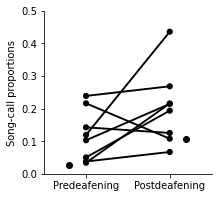

t(16) = -1.862484, p = 0.081 (two-sample t-test)
t(7) = -1.845, p = 0.108 (paired t-test)
Z = -1.634, p = 0.102 (rank-sum test)
Z = 5.0, p = 0.078 (signed-rank test)


In [9]:
plot_paired_data(df, x='taskName', y='songCallPropUndir',
                 y_label='Song-call proportions',
                 y_lim=[0, 0.5],
                 fig_size=(3, 3),
                 fig_name=f"Song_Call_Proportions (nb of bouts >= {nb_bout_crit}) Undir",
                 save_fig=False,
                 save_path=save_path,
                 color_by_bird=False,  # color-label birds
                 fig_ext='.png'
                 )
# Run stats
df_dropna = df_mean.dropna()  # remove if any of the columns is nan, used for paired comparisons

_, _, msg = two_sample_ttest(df_mean['Predeafening'].values, df_mean['Postdeafening'].values)
print(msg + " (two-sample t-test)")
_, _, msg = paired_ttest(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (paired t-test)")
_, _, msg = rank_sum_test(df_mean['Predeafening'].values, df_mean['Postdeafening'].values)
print(msg + " (rank-sum test)")
_, _, msg = signed_rank_test(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (signed-rank test)")

## Motif duration

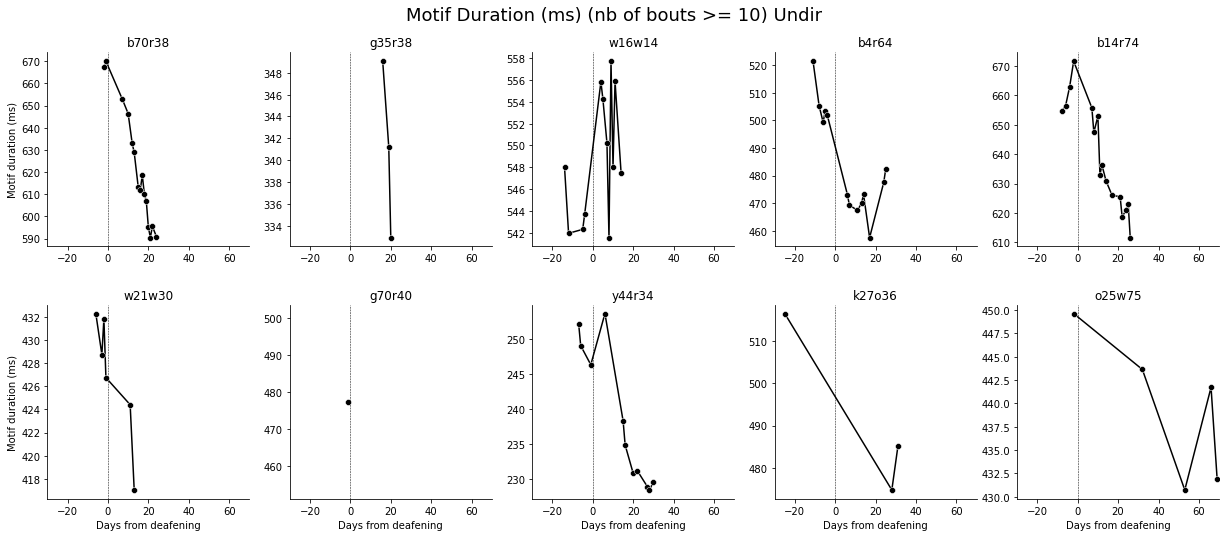

In [10]:
plot_across_days(df, x='taskSessionDeafening', y='motifDurationUndir', 
                 title=f"Motif Duration (ms) (nb of bouts >= {nb_bout_crit}) Undir",
                 x_lim=[-30, 70],
                 x_label='Days from deafening', y_label='Motif duration (ms)',
                 fig_ext=fig_ext,
                 save_fig=save_fig)

### Pre vs. Post

In [11]:
df_mean = df.groupby(['birdID', 'taskName'])['motifDurationUndir'].mean().reset_index()
df_mean = pd.pivot_table(data=df_mean,index=['birdID'], columns=['taskName'])['motifDurationUndir']
df_mean = df_mean.reindex(['Predeafening', 'Postdeafening'], axis=1)
df_dropna = df_mean.dropna()  # remove if any of the columns is nan, used for paired comparisons
df_dropna
df_mean

taskName,Predeafening,Postdeafening
birdID,,
b14r74,661.37300,631.852750
b4r64,506.32300,471.291750
b70r38,668.60450,614.933769
g35r38,NaN,341.062000
g70r40,477.45600,NaN
k27o36,516.47900,479.930500
o25w75,449.62900,437.001750
w16w14,544.00325,551.370125
w21w30,429.88400,420.723000


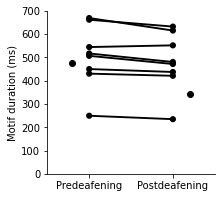

t(16) =  0.595786, p = 0.560 (two-sample t-test)
t(7) = 3.372, p = 0.012 (paired t-test)
Z =  0.751, p = 0.453 (rank-sum test)
Z = 1.0, p = 0.016 (signed-rank test)


In [12]:
plot_paired_data(df, x='taskName', y='motifDurationUndir',
                 y_label='Motif duration (ms)',
                 y_lim=[0, 700],
                 fig_size=(3, 3),
                 fig_name=f"Motif Duration (ms) (nb of bouts >= {nb_bout_crit}) Undir",
                 save_fig=False,
                 save_path=save_path,
                 color_by_bird=False,  # color-label birds
                 fig_ext='.png'
                 )
# Run stats
df_dropna = df_mean.dropna()  # remove if any of the columns is nan, used for paired comparisons

_, _, msg = two_sample_ttest(df_mean['Predeafening'].values, df_mean['Postdeafening'].values)
print(msg + " (two-sample t-test)")
_, _, msg = paired_ttest(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (paired t-test)")
_, _, msg = rank_sum_test(df_mean['Predeafening'].values, df_mean['Postdeafening'].values)
print(msg + " (rank-sum test)")
_, _, msg = signed_rank_test(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (signed-rank test)")

## CV (coefficient of variation) of Motif duration

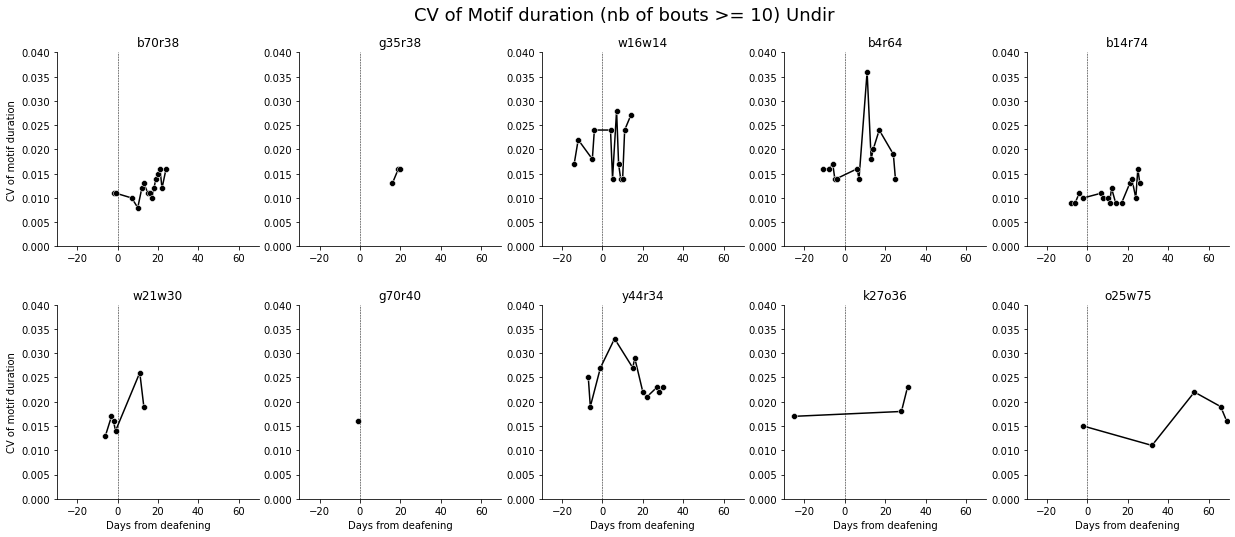

In [13]:
plot_across_days(df, x='taskSessionDeafening', y='motifDurationCVUndir',
                 title=f"CV of Motif duration (nb of bouts >= {nb_bout_crit}) Undir",
                 x_lim=[-30, 70],
                 y_lim=[0, 0.04],
                 x_label='Days from deafening', y_label='CV of motif duration',
                 fig_ext=fig_ext,
                 save_fig=save_fig)

### Pre vs. Post

In [14]:
df_mean = df.groupby(['birdID', 'taskName'])['motifDurationCVUndir'].mean().reset_index()
df_mean = pd.pivot_table(data=df_mean,index=['birdID'], columns=['taskName'])['motifDurationCVUndir']
df_mean = df_mean.reindex(['Predeafening', 'Postdeafening'], axis=1)
df_dropna = df_mean.dropna()  # remove if any of the columns is nan, used for paired comparisons
df_dropna
df_mean

taskName,Predeafening,Postdeafening
birdID,,
b14r74,0.009750,0.011333
b4r64,0.015400,0.020125
b70r38,0.011000,0.012308
g35r38,NaN,0.015000
g70r40,0.016000,NaN
k27o36,0.017000,0.020500
o25w75,0.015000,0.017000
w16w14,0.020250,0.020250
w21w30,0.015000,0.022500


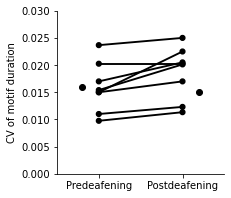

t(16) = -1.111729, p = 0.283 (two-sample t-test)
t(7) = -3.222, p = 0.015 (paired t-test)
Z = -1.104, p = 0.270 (rank-sum test)
Z = 0.0, p = 0.018 (signed-rank test)


In [15]:
plot_paired_data(df, x='taskName', y='motifDurationCVUndir',
                 y_label='CV of motif duration',
                 y_lim=[0, 0.03],
                 fig_size=(3, 3),
                 fig_name=f"Motif Duration (ms) (nb of bouts >= {nb_bout_crit}) Undir",
                 save_fig=False,
                 save_path=save_path,
                 color_by_bird=False,  # color-label birds
                 fig_ext='.png'
                 )
# Run stats
df_dropna = df_mean.dropna()  # remove if any of the columns is nan, used for paired comparisons

_, _, msg = two_sample_ttest(df_mean['Predeafening'].values, df_mean['Postdeafening'].values)
print(msg + " (two-sample t-test)")
_, _, msg = paired_ttest(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (paired t-test)")
_, _, msg = rank_sum_test(df_mean['Predeafening'].values, df_mean['Postdeafening'].values)
print(msg + " (rank-sum test)")
_, _, msg = signed_rank_test(df_dropna['Predeafening'].values, df_dropna['Postdeafening'].values)
print(msg + " (signed-rank test)")

## Plot across day blocks

In [16]:
df_block = df.groupby(['birdID', 'block10days'])['meanIntroUndir', 'songCallPropUndir', 'motifDurationUndir', 'motifDurationCVUndir'].mean().reset_index() 
save_fig = False
fig_ext = '.png'

In [19]:
def plot_across_blocks(df_block, variable, 
                       y_lim=None, fig_size=(4, 3),
                       y_label=None, 
                       fig_name=None, 
                       save_fig=False, save_path=None, 
                       fig_ext='.png'
                       ):
    
    from util.draw import remove_right_top
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    plt.suptitle(fig_name, y=1, fontsize=12)
    sns.lineplot('block10days', variable, hue='birdID', marker='o', data=df_block, ax=ax)
    remove_right_top(ax)
    ax.set_xlabel(''), ax.set_ylabel(y_label)
    ax.set_ylim(y_lim)
    day_block_label_list = ['Predeafening', 'Day 4-10', 'Day 11-20', 'Day >= 21']
    ax.set_xticklabels(day_block_label_list, rotation=45)
    ax.set_xticklabels(day_block_label_list, rotation=45)
    ax.set_xticks([0, 1, 2, 3])
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

    # Run one-way ANOVA
    import scipy.stats as stats
    f_val, p_val = stats.f_oneway(
                                  df_block[variable][df_block['block10days'] == 0],
                                  df_block[variable][df_block['block10days'] == 1],
                                  df_block[variable][df_block['block10days'] == 2],
                                  df_block[variable][df_block['block10days'] == 3],
                                  )

    msg = f"""F ={f_val: 0.3f}, p ={p_val: 0.3f} (One-way ANOVA)"""
    if save_fig:
        save.save_fig(fig, save_path, fig_name, view_folder=view_folder, fig_ext=fig_ext)
    else:
        plt.show()
    print(msg)  

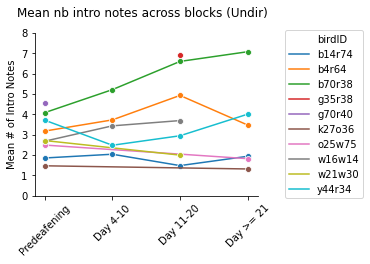

F = 0.593, p = 0.626 (One-way ANOVA)


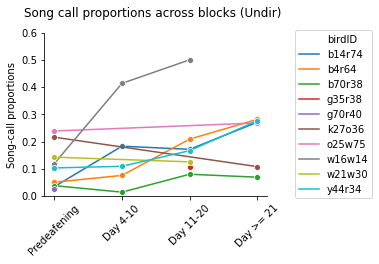

F = 1.201, p = 0.332 (One-way ANOVA)


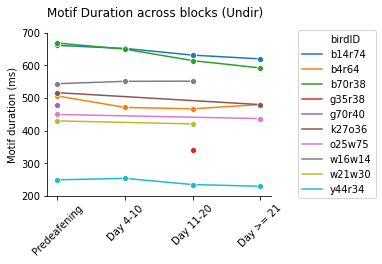

F = 0.165, p = 0.919 (One-way ANOVA)


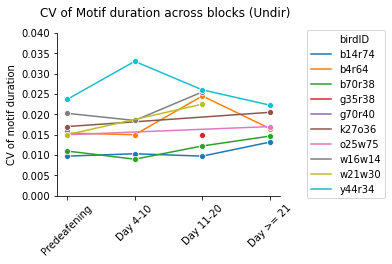

F = 0.425, p = 0.737 (One-way ANOVA)


In [20]:
# Mean # of intro notes
plot_across_blocks(df_block, variable='meanIntroUndir', 
                   fig_name='Mean nb intro notes across blocks (Undir)',
                   y_lim=[0, 8], 
                   y_label='Mean # of Intro Notes', 
                   save_fig=save_fig, fig_ext=fig_ext
                   )

# Song-call proportions
plot_across_blocks(df_block, variable='songCallPropUndir', 
                   fig_name=f"Song call proportions across blocks (Undir)",
                   y_lim=[0, 0.6], 
                   y_label='Song-call proportions', 
                   save_fig=save_fig, fig_ext=fig_ext
                   )

# Motif duration
plot_across_blocks(df_block, variable='motifDurationUndir', 
                   fig_name=f"Motif Duration across blocks (Undir)",
                   y_lim=[200, 700], 
                   y_label='Motif duration (ms)',
                   save_fig=save_fig, fig_ext=fig_ext
                  )

# CV of motif durations
plot_across_blocks(df_block, variable='motifDurationCVUndir',
                   fig_name=f"CV of Motif duration across blocks (Undir)",
                   y_lim=[0, 0.04],
                   y_label='CV of motif duration',
                   save_fig=save_fig, fig_ext=fig_ext
                  )